In [3]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torchvision.utils import save_image
from typing import Tuple, List, Dict, Union, Any, cast
import os

# from mnist.model import VAEMNIST
from mnist.model_burgess import VAE

In [5]:
batch_size = 128
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
DATA_PATH = '../../data'
SUB_PATH = os.path.join(DATA_PATH, 'mnist-experiments')
print(os.path.abspath(DATA_PATH))
train_set = datasets.MNIST(DATA_PATH, train=True, download=True,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size, shuffle=True)
test_set = datasets.MNIST(DATA_PATH, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size, shuffle=False)

/home/andries/projects/mai-thesis-public/data


In [14]:
# from mnist import model

# SET BETA HERE
beta = 1
epochs = 10

# model = VAEMNIST()
model = VAE()
weights = torch.load(os.path.join(SUB_PATH, f'model_burgess_ep{epochs}_beta{str(beta)}_00.pt'))

model.load_state_dict(weights)

<All keys matched successfully>

In [15]:
with open(os.path.join(SUB_PATH, f'latent_kl_loss_beta{str(beta)}_00.txt')) as file:
    last_lines = file.readlines()[-10:]
kl_losses = {l.split(",")[2]: l.split(",")[3].strip() for l in last_lines}
kl_losses

{'kl_loss_0': '1.930552363395691',
 'kl_loss_1': '1.512842059135437',
 'kl_loss_2': '2.4743993282318115',
 'kl_loss_3': '2.288334846496582',
 'kl_loss_4': '1.297842264175415',
 'kl_loss_5': '1.8536850214004517',
 'kl_loss_6': '1.8206459283828735',
 'kl_loss_7': '1.8235132694244385',
 'kl_loss_8': '1.8618369102478027',
 'kl_loss_9': '1.3277292251586914'}

In [16]:

from matplotlib import cm
import matplotlib.pyplot as plt
from numpy import int_
from sympy import plot

def get_average_latent_activation(model, test_data):
    """Returns tensor of shape [10, 1, 32, 32]"""
    average_z = torch.zeros((10, 1, 32, 32))
    count = 0
    for data, labels in test_data:
        # print(data.shape, labels.shape)
        batch_size = data.size(0)
        recon, mu, log_var, sample = model(data)
        # print(recon.shape, mu.shape, log_var.shape)

        std = torch.exp(0.5 * log_var)
        z = mu + std # shape [128, 10]

        for b in range(batch_size):
            z_batch_item = z[b]
            img = data[b]
            for z_index in range(10):
                z_val = z_batch_item[z_index]
                average_z[z_index] += z_val * img
            
        count += batch_size

    average_z /= count

    return average_z

average_tensor = get_average_latent_activation(model, test_loader)
print(average_tensor.shape)

torch.Size([10, 1, 32, 32])


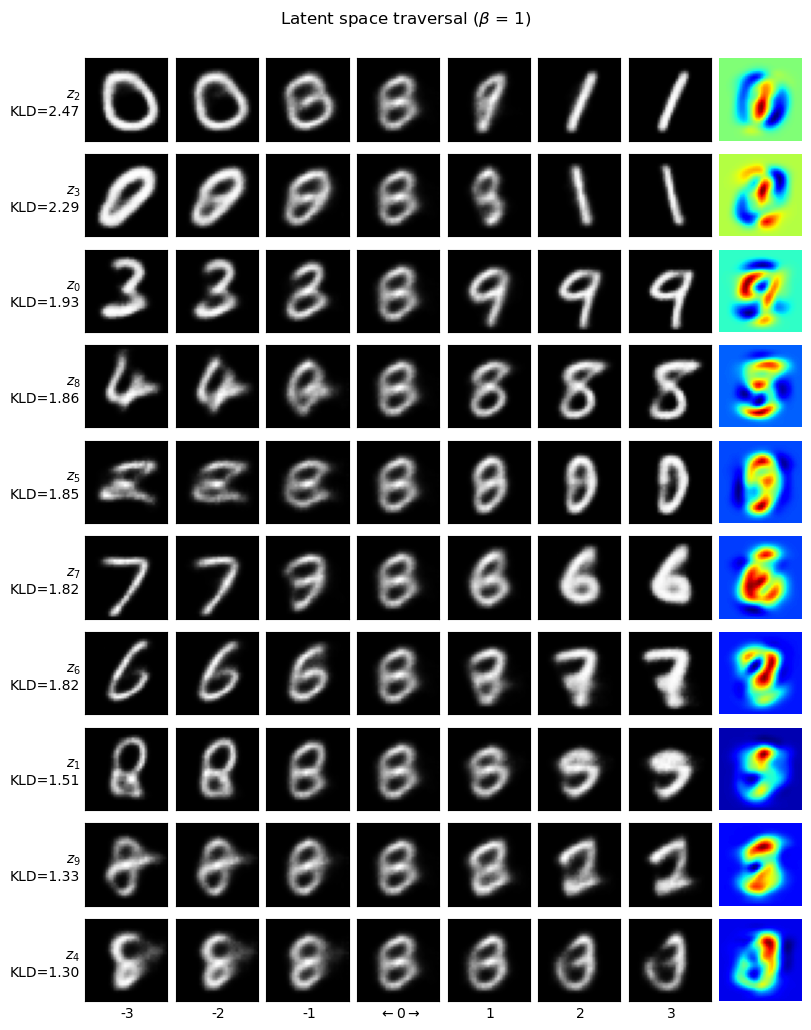

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid

def get_model_latent_mean_traversal_grid(model):
    kl_losses_num = [kl_losses[k] for k in kl_losses]
    sorted_indexes = np.argsort(kl_losses_num)[::-1].tolist()
    sorted_var = [float(kl_losses_num[s]) for s in sorted_indexes]
    # print(sorted_var)

    # init z
    grid = torch.zeros((10, 7, 1, 32, 32))
    
    # Latent variables for existing input images of number '4'
    # You can pick others as a baseline (or just use the 'zeros')
    z_base = torch.zeros((1, 10))
    z_4_beta1 = torch.tensor([[ 1.7771, -1.1275,  0.4400,  0.1337, -2.0844, -0.6323,  1.4844, -0.7649,
          0.8271, -1.3180]])
    z_4_beta4 = torch.tensor([[-0.0380, -0.3727, -0.9713, -0.0492,  0.2642,  0.5622,  1.1105,  1.4968,
         -0.1407,  1.1594]])
    
    std_space = np.linspace(-3, 3, 7)
    for i, z_index in enumerate(sorted_indexes):
        for idx, s in enumerate(std_space):
            z_clone = z_4_beta1.clone()

            z_clone[0][z_index] = z_clone[0][z_index].item() + s
            recon_z = model.decode(z_clone).clone()
            grid[i][idx] = recon_z

    # save_image(grid.view(10 * 7, 1, 32, 32), 'mnist/results/beta1_00.png', nrow=7)
    return grid, sorted_indexes, sorted_var

# Plot the grid
grid, sorted_indexes, sorted_var = get_model_latent_mean_traversal_grid(model)

def plot_all(grid, average_tensor, beta):
    # grid = grid.view(10, 7, 1, 32, 32)
    h = grid.shape[0]
    w = grid.shape[1]

     # Define the labels for the x-ticks
    x_ticks_labels = [x for x in [-3, -2, -1, r'$\leftarrow$0$\rightarrow$', 1, 2, 3]]  # Replace this with your actual labels
    y_ticks_labels_1 = [f"$z_{x}$" for x in sorted_indexes]
    y_ticks_labels_2 = [f"{x:.2f}" for x in sorted_var]
    y_ticks_labels_zip = [j + "\nKLD=" + i for i, j in zip(y_ticks_labels_2, y_ticks_labels_1)]


    fig, ax = plt.subplots(h, w+1, figsize=(w+1, h), constrained_layout=True)
    for i in range(h):
        for j in range(w+1):

            if j != w:
                ax[i, j].imshow(grid[i][j].permute(1, 2, 0).detach().numpy(), cmap='grey')
            
                if i == h -1:
                    ax[i, j].set_xticks([32/2])
                    ax[i, j].set_xticklabels([x_ticks_labels[j]], fontsize='medium')
                    ax[i, j].tick_params(axis='x', which='both', length=0)
                else:
                    ax[i, j].get_xaxis().set_visible(False)
                if j == 0:
                    ax[i, j].set_yticks([32/2])
                    ax[i, j].set_yticklabels([y_ticks_labels_zip[i]], fontsize='medium')
                    ax[i, j].tick_params(axis='y', which='both', length=0)
                else:
                    ax[i, j].get_yaxis().set_visible(False)

            else:
                idx = sorted_indexes[i]
                ax[i, j].imshow(average_tensor[idx].squeeze().detach().numpy(), cmap='jet')
                ax[i, j].axis('off')
    fig.suptitle(f"Latent space traversal ($\\beta$ = {beta})",ha='center',va='bottom')
    plt.show()

plot_all(grid, average_tensor, beta)


In [18]:

from matplotlib import cm
import matplotlib.pyplot as plt
from numpy import int_
from sympy import plot

def get_average_latent_activation(model, test_data):
    """Returns tensor of shape [10, 1, 32, 32]"""
    average_z = torch.zeros((10, 1, 32, 32))
    count = 0
    for data, labels in test_data:
        # print(data.shape, labels.shape)
        batch_size = data.size(0)
        recon, mu, log_var, sample = model(data)
        # print(recon.shape, mu.shape, log_var.shape)

        std = torch.exp(0.5 * log_var)
        z = mu + std # shape [128, 10]

        for b in range(batch_size):
            z_batch_item = z[b]
            img = data[b]
            for z_index in range(10):
                z_val = z_batch_item[z_index]
                average_z[z_index] += z_val * img
            
        count += batch_size

    average_z /= count

    return average_z
        
    # recon, mu, log_var = model(img_t.unsqueeze(0))

average_tensor = get_average_latent_activation(model, test_loader)

# torch.min(average_tensor), torch.max(average_tensor)

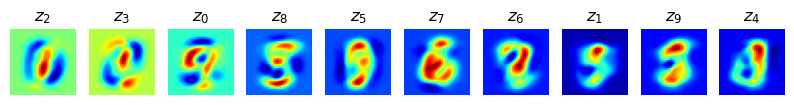

In [19]:
num_images = 10
fig, axs = plt.subplots(1, 10, figsize=(10, 2))

for i, s in enumerate(sorted_indexes):
    axs[i].imshow(average_tensor[s].squeeze().detach().numpy(), cmap='jet')
    axs[i].axis('off')
    axs[i].set_title(f"$z_{s}$")


plt.show()

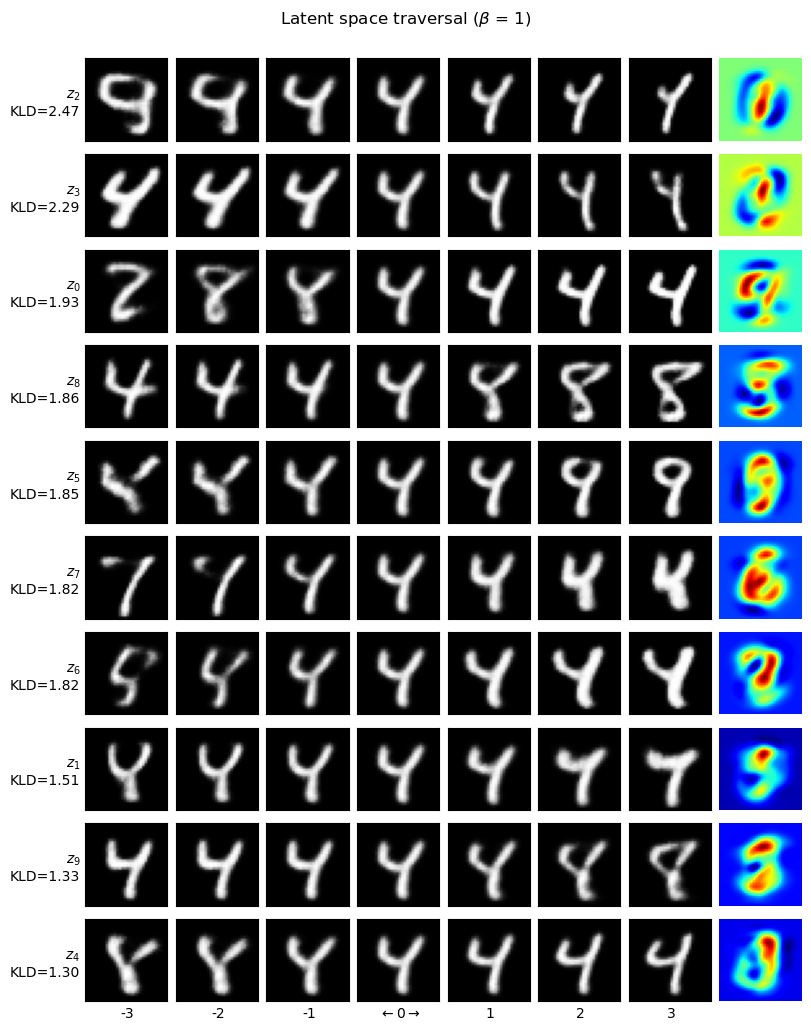

In [20]:

plot_all(grid, average_tensor=average_tensor, beta=beta)